# Numerické řešení p-laplacian problému na vlastní čísla v 2D

Založeno na [Gridap tutorials](https://gridap.github.io/Tutorials/stable/), speciálně [Tutorial 4: p-Laplacian](https://gridap.github.io/Tutorials/stable/pages/t004_p_laplacian/) a pro 2D [Tutorial 7: Darcy equation (with RT)](https://gridap.github.io/Tutorials/stable/pages/t007_darcy/). Na mesh používáme [Gmsh](https://gmsh.info/) a [GridapGmsh.jl](https://github.com/gridap/GridapGmsh.jl). Na vykreslení řešení pak [Makie.jl](https://makie.juliaplots.org/stable/) a [GridapMakie.jl](https://github.com/gridap/GridapMakie.jl)

TODO:
- odladit pro p=1.5 (ostatní hodnoty zdá se fungují)
- ~~jak definovat jinou geomerii? Primárně kouli, ale obecně cokoliv. https://gmsh.info/~~
- ~~vykreslit řešení přímo v notebooku. https://github.com/gridap/GridapMakie.jl~~
    - zajímavý návod jak kreslit v 3D https://github.com/gridap/Tutorials/pull/36 
- ~~jak získat řešení ve formě pro další výpočty?~~ Stačí ho jen dosadit do slabé formy řešení
    - je potřeba ale definovat extra funkci pravé strany (tedy $v(u/\lVert u \lVert_\infty)^{q-1}$) a pak zavolat tu. Pokud vlžím výraz přímo do residua $r(u,v)$ tak nefunguje (neumí jak mocninu tak násobení)
- asi budem potřebovat i mesh a jeho souřadnice 
    - https://github.com/gridap/Gridap.jl/issues/345 
    - https://github.com/gridap/Tutorials/pull/36
- zapojit DrWatson (https://juliadynamics.github.io/DrWatson.jl/stable/)
    
    
Pro algoritmus na $\lambda_1$:
- ~~jak definovat $f(x)$ (pravou stranu) jako diskrétní fci na meshi~~ snadno, viz nahoře

In [1]:
using Gridap, GridapGmsh, GridapMakie
using GLMakie
using FileIO
import Random
using LinearAlgebra: norm
using LineSearches: BackTracking
using Gridap.Geometry
using Gridap.ReferenceFEs

### Konstrukce 2D sítě

In [2]:
@time begin
    #### unit square
    #domain = (0,1,0,1)
    #partition = (100,100)
    #model = CartesianDiscreteModel(domain,partition) 

    #### unit 2D ball
    model = GmshDiscreteModel("models/disk.msh") ;

    ### save model for Paraview
    #writevtk(model,"models/disk")
end

Info    : Reading 'models/disk.msh'...
Info    : 10 entities
Info    : 7297 nodes
Info    : 14592 elements
Info    : Done reading 'models/disk.msh'
  5.076722 seconds (13.50 M allocations: 796.530 MiB, 2.76% gc time, 99.21% compilation time)


UnstructuredDiscreteModel()

### Definice test a trial prostorů

In [3]:
@time begin
    reffe = ReferenceFE(lagrangian,Float64,1)
    V0 = TestFESpace(model,reffe,conformity=:H1, dirichlet_tags="bnd") # dirichlet všude na hranici. Ta je v modelu označena bnd
    g = 0 # okrajové podmínky
    Ug = TrialFESpace(V0,g)
end

 18.449826 seconds (65.50 M allocations: 4.032 GiB, 4.51% gc time, 99.93% compilation time)


TrialFESpace()

### Triangulace modelu a definice Lebesguovy míry

TODO:
- zjistit víc o stupni

In [4]:
degree=2
Ω = Triangulation(model)
dΩ = Measure(Ω,degree)

Measure()

### Vykreslení meshe

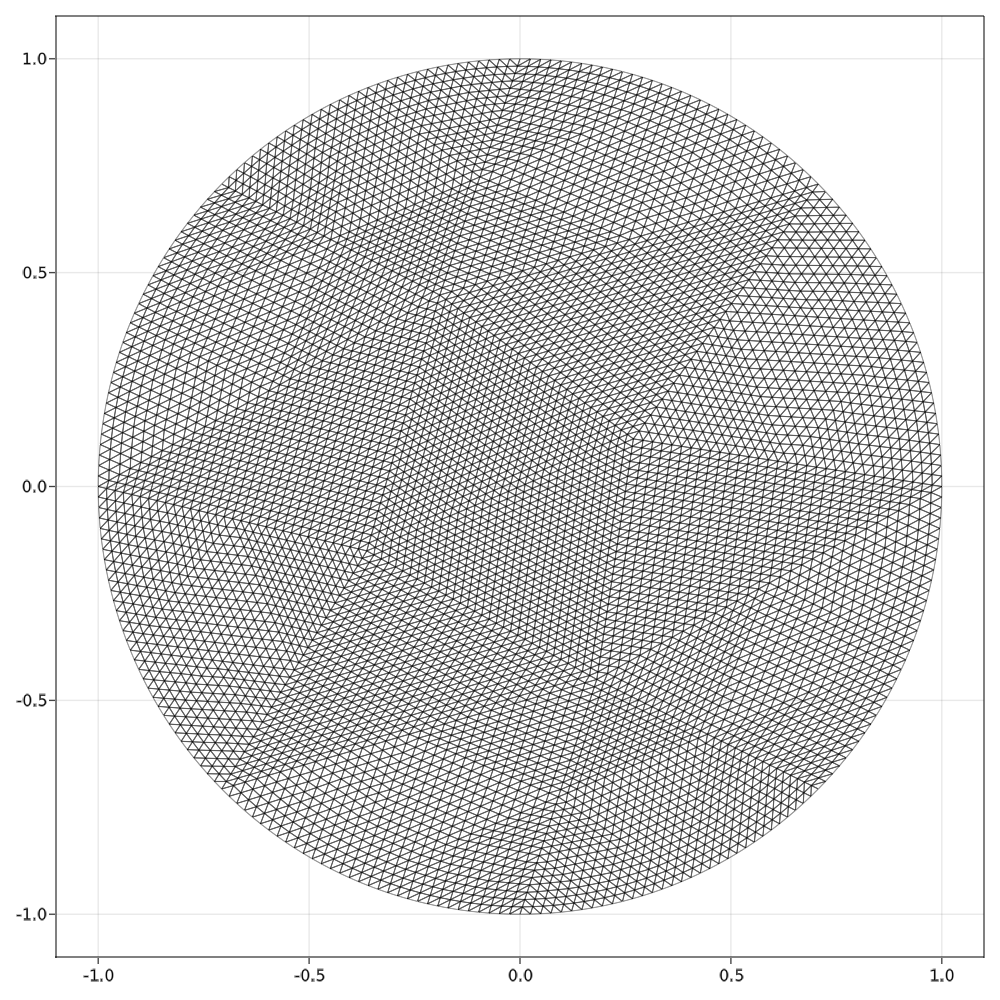

In [5]:
wireframe(Ω, color=:black, linewidth=.5, figure=(resolution=(1000,1000),))

## p=2

### Definice slabého residuálu $res(u,v)$ a jakobiánu $jac$

- nastavení konkrétního $p$

In [6]:
p = 2

flux(∇u) = norm(∇u)^(p-2) * ∇u
f(x) = 1
res(u,v) = ∫( ∇(v)⊙(flux∘∇(u)) - v*f )*dΩ

dflux(∇du,∇u) = (p-2)*norm(∇u)^(p-4)*(∇u⊙∇du)*∇u+norm(∇u)^(p-2)*∇du
jac(u,du,v) = ∫( ∇(v)⊙(dflux∘(∇(du),∇(u))) )*dΩ

op = FEOperator(res,jac,Ug,V0)

FEOperatorFromWeakForm()

### Definice řešiče

In [7]:
nls = NLSolver(
  show_trace=false, method=:newton, linesearch=BackTracking()) # show_trace --> vypíše průběh řešiče
solver = FESolver(nls)

NonlinearFESolver()

### Řešení $uh$

In [8]:
@time begin
    Random.seed!(1234)
    x = rand(Float64,num_free_dofs(Ug))
    uh0 = FEFunction(Ug,x)
    uh, = solve!(uh0,solver,op)
    #writevtk(Ω,"results2D_disk",cellfields=["uh"=>uh]) #zápis do souboru pro Paraview
end

 24.335103 seconds (80.48 M allocations: 4.767 GiB, 4.65% gc time, 99.30% compilation time)


(SingleFieldFEFunction(), NLSolversCache())

### Algoritmus výpočtu prvního vlastního čísla a první vlastní funkce

Založeno na článku [Computing the First Eigenpair of the p-Laplacian via Inverse Iteration of Sublinear Supersolutions](https://www.researchgate.net/publication/226060248_Computing_the_First_Eigenpair_of_the_p-Laplacian_via_Inverse_Iteration_of_Sublinear_Supersolutions)

1: set $q$ as $p-0.01$  
2: solve $-\Delta_p u_0 = 1$ in $\Omega$, $u_0 = 0$ on $\partial \Omega$  
3: for $m = 0,1,2, \dots$ do  
4: &nbsp;&nbsp;&nbsp;&nbsp;solve $-\Delta_p u_{m+1} = (u_m/\lVert u_m \lVert_\infty)^{q-1}$ in $\Omega$, $u_0 = 0$ on $\partial \Omega$  
5: return $\lambda_1 = 1/\lVert u_{m+1} \lVert_\infty^{p-1}$  (first eigenvalue)  
6: return $e_1 = u_{m+1}/\lVert u_{m+1} \lVert_\infty$ (first eigenfunction)

... $u_0$ už mám, začnu tedy bodem 3. Jen se opakuje předchozí kód ale v $res(u,v)$ je na rhs dosazené předchozí řešení

In [9]:
#p = 3
#flux(∇u) = norm(∇u)^(p-2) * ∇u
#dflux(∇du,∇u) = (p-2)*norm(∇u)^(p-4)*(∇u⊙∇du)*∇u+norm(∇u)^(p-2)*∇du
#jac(u,du,v) = ∫( ∇(v)⊙(dflux∘(∇(du),∇(u))) )*dΩ
@time begin
    q = p-.01
    pts = get_node_coordinates(Ω) # potřebujeme k evaluaci řešení v uzlových bodech

    for m in 0:8
        #println(m)
        uhsup = maximum(abs.(lazy_map(uh,pts)))
        println("$(m+1). iterace: λ₁ ≈ $(1/uhsup^(p-1))")
        raiseprw(g1,g2) = g1*(g2/uhsup)^(q-1)
        res(u,v) = ∫( ∇(v)⊙(flux∘∇(u)) - raiseprw∘(v,uh) )*dΩ
        op = FEOperator(res,jac,Ug,V0)

        Random.seed!(1234)
        x = rand(Float64,num_free_dofs(Ug))
        uh0 = FEFunction(Ug,x)
        uh, = solve!(uh0,solver,op);

    end
end

1. iterace: λ₁ ≈ 3.998506255883977
2. iterace: λ₁ ≈ 5.319310598885563
3. iterace: λ₁ ≈ 5.663640647711651
4. iterace: λ₁ ≈ 5.740276600459158
5. iterace: λ₁ ≈ 5.755890768510136
6. iterace: λ₁ ≈ 5.758935484696586
7. iterace: λ₁ ≈ 5.759517310683049
8. iterace: λ₁ ≈ 5.759627511245418
9. iterace: λ₁ ≈ 5.759648305074521
 69.526479 seconds (124.13 M allocations: 29.345 GiB, 2.86% gc time, 4.62% compilation time)


### První vlastní číslo $\lambda_1$ a první vlastní funkce $e_1$

Grafy podle tutorialu: [GridapMakie](https://github.com/gridap/GridapMakie.jl)

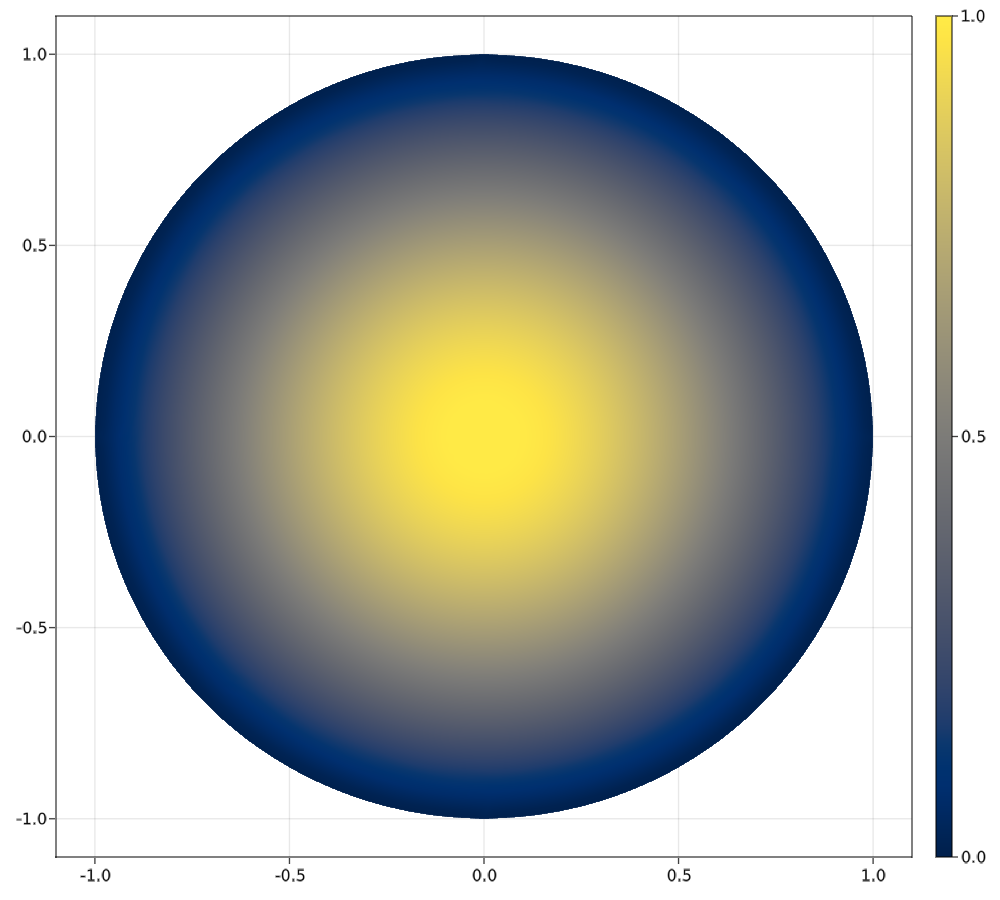

První vlastní číslo pro p=2: λ₁ ≈ 5.759652222528304


In [10]:
# souřadnice sítě
#x = collect(vec(lazy_map(pt -> pt[1], pts)));
#y = collect(vec(lazy_map(pt -> pt[2], pts)));
# hodnota první vlastní funkce v uzlových bodech sítě
uhsup = maximum(abs.(lazy_map(uh,pts)))
#z = collect(vec(lazy_map(uh,pts) ))./uhsup;

#2D graf první vlastní funkce
GLMakie.inline!(true)
fig, _ , plt = plot(Ω, uh./uhsup, colormap=:cividis, figure=(resolution=(1000,900),))
Colorbar(fig[1,2], plt)
display(fig) #save("images/2d_Fig11.png", fig)

# první vlastní číslo
println("První vlastní číslo pro p=$(p): λ₁ ≈ $(1/(maximum(abs.(lazy_map(uh,pts))))^(p-1))")

In [11]:
# 3D verze grafu e₁
# meshscatter(x,y,z, color=z, colormap=:cividis, markersize=1e-2)

In [12]:
## interaktivní graf
# nefunguje v JupyterLab, v Notebooku ano: https://discourse.julialang.org/t/makie-3d-plot-cannot-rotate-in-jupyter-notebook/68191

#GLMakie.inline!(false)
#fig=meshscatter(x,y,z, color=z, colormap=:cividis, markersize=2e-2)
#display(fig)

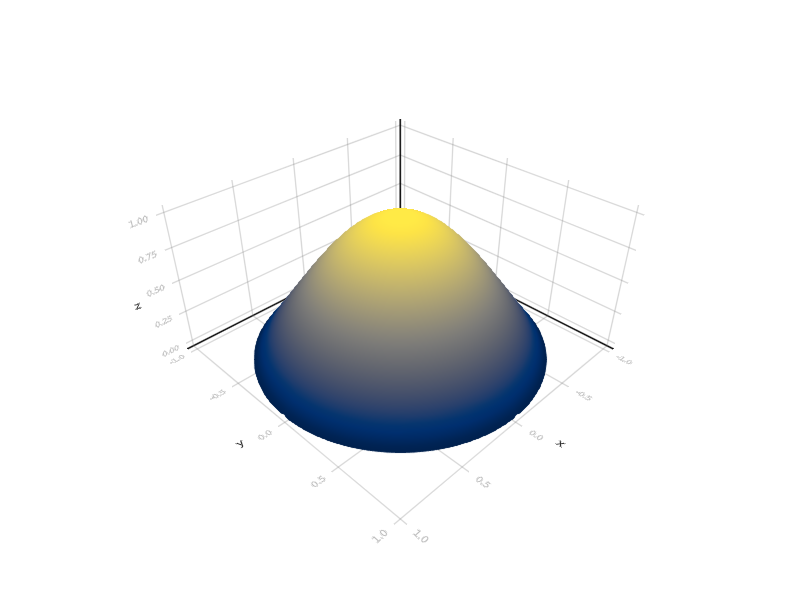

In [13]:
function to_makie_matrix(T, itr)
    x1 = first(itr)
    out = Matrix{T}(undef, length(itr), length(x1))
    for i in 1:length(itr)
        for j in 1:length(x1)
            out[i, j] = itr[i][j]
        end
    end
    out
end

makie_coords = to_makie_matrix(Float64, pts)
makie_conn = to_makie_matrix(Int, get_cell_node_ids(Ω))
uhsup = maximum(abs.(lazy_map(uh,pts)))
color = vec(map(uh, pts))./uhsup
makie_coords = hcat(makie_coords, color)


mesh(makie_coords, makie_conn, color = color, colormap=:cividis, shading = false)


## p=3

In [14]:
p = 3

flux(∇u) = norm(∇u)^(p-2) * ∇u
f(x) = 1
res(u,v) = ∫( ∇(v)⊙(flux∘∇(u)) - v*f )*dΩ

dflux(∇du,∇u) = (p-2)*norm(∇u)^(p-4)*(∇u⊙∇du)*∇u+norm(∇u)^(p-2)*∇du
jac(u,du,v) = ∫( ∇(v)⊙(dflux∘(∇(du),∇(u))) )*dΩ

op = FEOperator(res,jac,Ug,V0)

nls = NLSolver(
  show_trace=false, method=:newton, linesearch=BackTracking()) # show_trace --> vypíše průběh řešiče
solver = FESolver(nls)


Random.seed!(1234)
x = rand(Float64,num_free_dofs(Ug))
uh0 = FEFunction(Ug,x)
uh, = solve!(uh0,solver,op)

q = p-.01
pts = get_node_coordinates(Ω) # potřebujeme k evaluaci řešení v uzlových bodech

for m in 0:8
    #println(m)
    uhsup = maximum(abs.(lazy_map(uh,pts)))
    println("$(m+1). iterace: λ₁ ≈ $(1/uhsup^(p-1))")
    raiseprw(g1,g2) = g1*(g2/uhsup)^(q-1)
    res(u,v) = ∫( ∇(v)⊙(flux∘∇(u)) - raiseprw∘(v,uh) )*dΩ
    op = FEOperator(res,jac,Ug,V0)

    Random.seed!(1234)
    x = rand(Float64,num_free_dofs(Ug))
    uh0 = FEFunction(Ug,x)
    uh, = solve!(uh0,solver,op);

end


1. iterace: λ₁ ≈ 4.5032295793945005
2. iterace: λ₁ ≈ 8.301540268711554
3. iterace: λ₁ ≈ 9.477856260645686
4. iterace: λ₁ ≈ 9.736036564179996
5. iterace: λ₁ ≈ 9.784943451008656
6. iterace: λ₁ ≈ 9.793632585121644
7. iterace: λ₁ ≈ 9.795134171116898
8. iterace: λ₁ ≈ 9.79539076214308
9. iterace: λ₁ ≈ 9.795434484559909


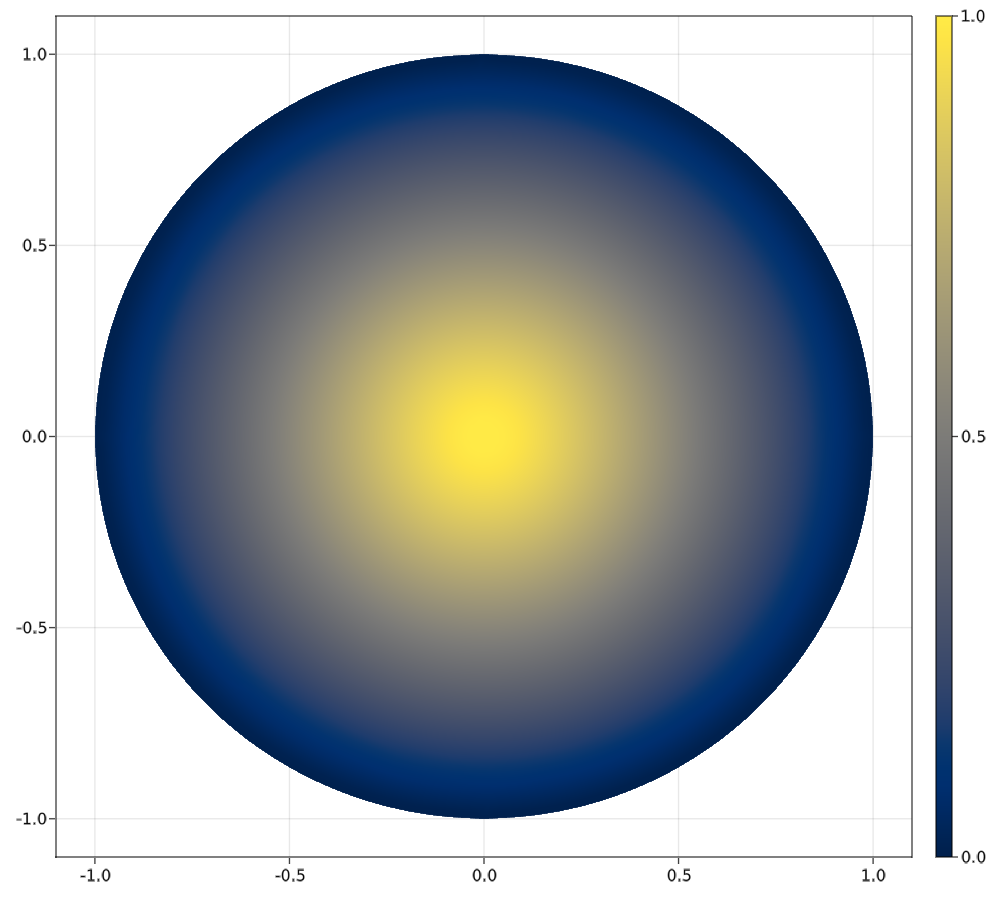

První vlastní číslo pro p=3: λ₁ ≈ 9.795441965637895


In [15]:
uhsup = maximum(abs.(lazy_map(uh,pts)))

#2D graf první vlastní funkce
GLMakie.inline!(true)
fig, _ , plt = plot(Ω, uh./uhsup, colormap=:cividis, figure=(resolution=(1000,900),))
Colorbar(fig[1,2], plt)
display(fig) #save("images/2d_Fig11.png", fig)

# první vlastní číslo
println("První vlastní číslo pro p=$(p): λ₁ ≈ $(1/(maximum(abs.(lazy_map(uh,pts))))^(p-1))")

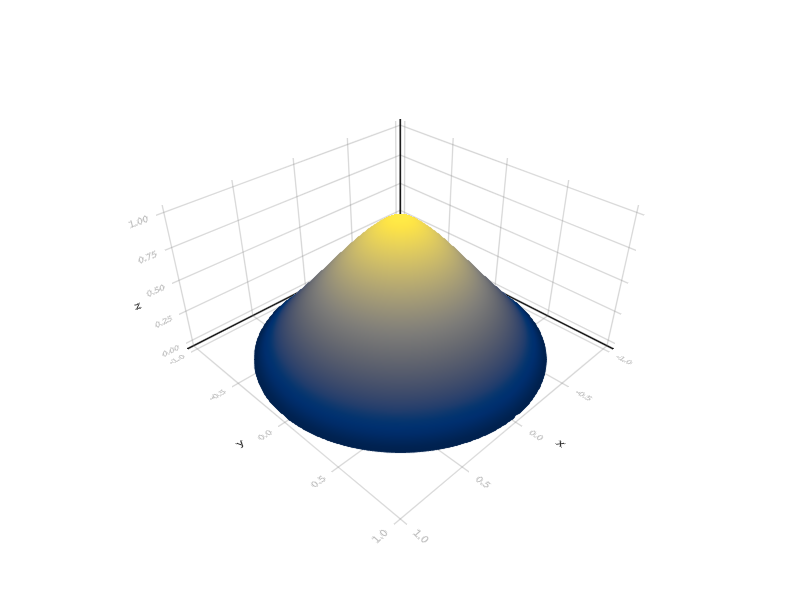

In [16]:
function to_makie_matrix(T, itr)
    x1 = first(itr)
    out = Matrix{T}(undef, length(itr), length(x1))
    for i in 1:length(itr)
        for j in 1:length(x1)
            out[i, j] = itr[i][j]
        end
    end
    out
end

makie_coords = to_makie_matrix(Float64, pts)
makie_conn = to_makie_matrix(Int, get_cell_node_ids(Ω))
uhsup = maximum(abs.(lazy_map(uh,pts)))
color = vec(map(uh, pts))./uhsup
makie_coords = hcat(makie_coords, color)


mesh(makie_coords, makie_conn, color = color, colormap=:cividis, shading = false)


# p=1.3

In [17]:
p = 1.3

flux(∇u) = norm(∇u)^(p-2) * ∇u
f(x) = 1
res(u,v) = ∫( ∇(v)⊙(flux∘∇(u)) - v*f )*dΩ

dflux(∇du,∇u) = (p-2)*norm(∇u)^(p-4)*(∇u⊙∇du)*∇u+norm(∇u)^(p-2)*∇du
jac(u,du,v) = ∫( ∇(v)⊙(dflux∘(∇(du),∇(u))) )*dΩ

op = FEOperator(res,jac,Ug,V0)

nls = NLSolver(
  show_trace=false, method=:newton, linesearch=BackTracking()) # show_trace --> vypíše průběh řešiče
solver = FESolver(nls)


Random.seed!(1234)
x = rand(Float64,num_free_dofs(Ug))
uh0 = FEFunction(Ug,x)
uh, = solve!(uh0,solver,op)

q = p-.01
pts = get_node_coordinates(Ω) # potřebujeme k evaluaci řešení v uzlových bodech

for m in 0:8
    #println(m)
    uhsup = maximum(abs.(lazy_map(uh,pts)))
    println("$(m+1). iterace: λ₁ ≈ $(1/uhsup^(p-1))")
    raiseprw(g1,g2) = g1*(g2/uhsup)^(q-1)
    res(u,v) = ∫( ∇(v)⊙(flux∘∇(u)) - raiseprw∘(v,uh) )*dΩ
    op = FEOperator(res,jac,Ug,V0)

    Random.seed!(1234)
    x = rand(Float64,num_free_dofs(Ug))
    uh0 = FEFunction(Ug,x)
    uh, = solve!(uh0,solver,op);

end


1. iterace: λ₁ ≈ 3.102895819344028
2. iterace: λ₁ ≈ 3.282006451294282
3. iterace: λ₁ ≈ 3.310586682046299
4. iterace: λ₁ ≈ 3.3149571281501964
5. iterace: λ₁ ≈ 3.3155984677884556
6. iterace: λ₁ ≈ 3.315690639527793
7. iterace: λ₁ ≈ 3.315703767489638
8. iterace: λ₁ ≈ 3.315705630492572
9. iterace: λ₁ ≈ 3.3157058944951023


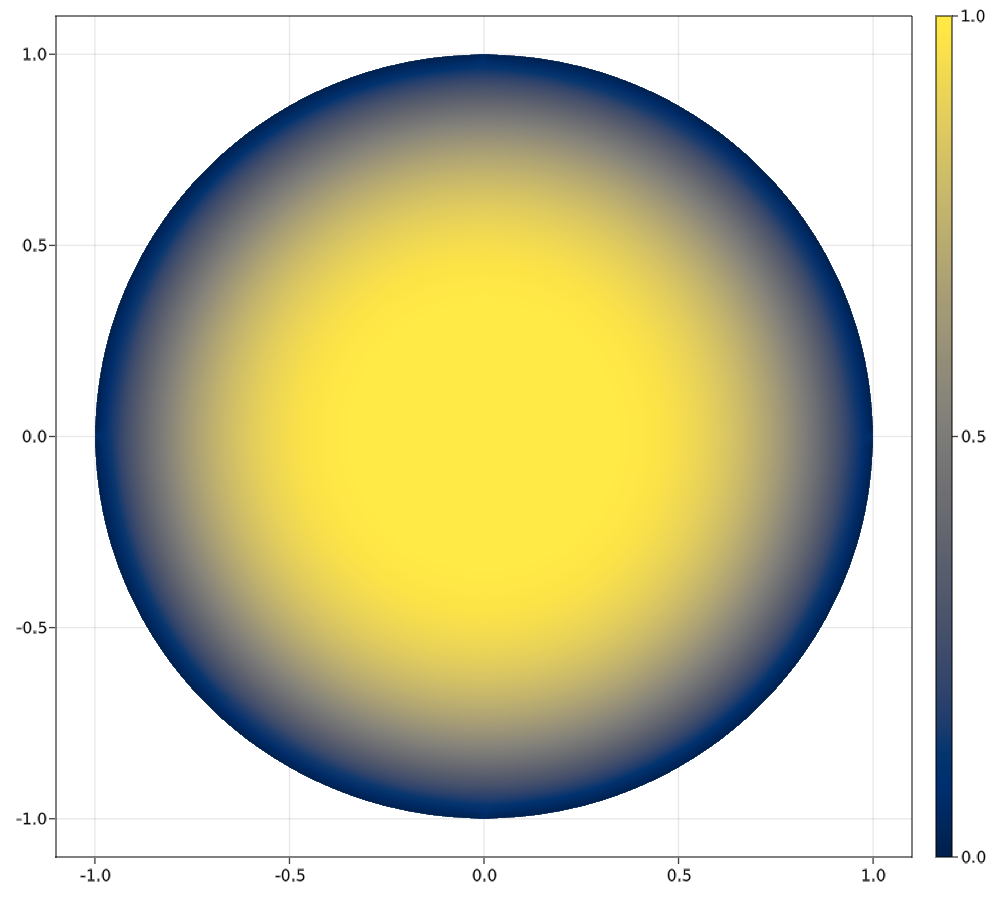

První vlastní číslo pro p=1.3: λ₁ ≈ 3.3157059318856983


In [18]:
uhsup = maximum(abs.(lazy_map(uh,pts)))

#2D graf první vlastní funkce
GLMakie.inline!(true)
fig, _ , plt = plot(Ω, uh./uhsup, colormap=:cividis, figure=(resolution=(1000,900),))
Colorbar(fig[1,2], plt)
display(fig) #save("images/2d_Fig11.png", fig)

# první vlastní číslo
println("První vlastní číslo pro p=$(p): λ₁ ≈ $(1/uhsup^(p-1))")

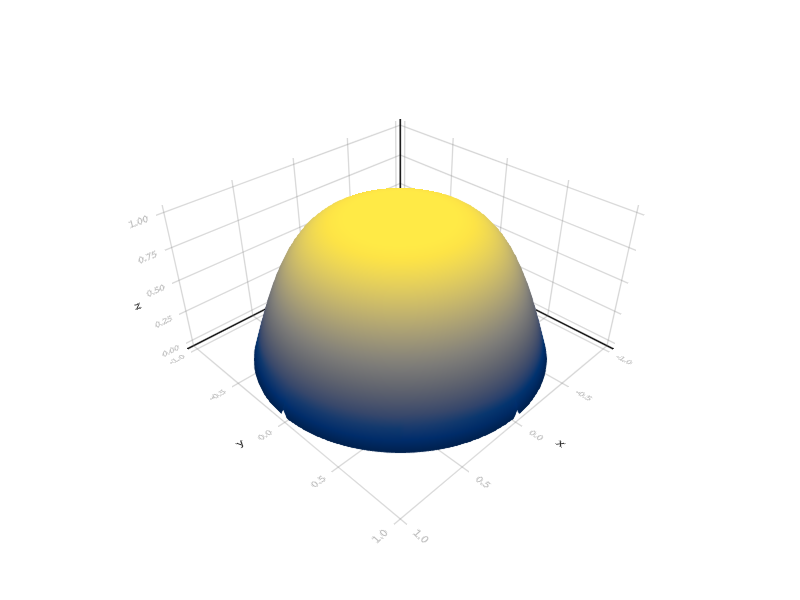

In [19]:
makie_coords = to_makie_matrix(Float64, pts)
makie_conn = to_makie_matrix(Int, get_cell_node_ids(Ω))
uhsup = maximum(abs.(lazy_map(uh,pts)))
color = vec(map(uh, pts))./uhsup
makie_coords = hcat(makie_coords, color)

mesh(makie_coords, makie_conn, color = color, colormap=:cividis, shading = false)